In [1]:
import os
import yaml
from omegaconf import DictConfig
import pandas as pd
import numpy as np
import csv

In [2]:
import os
import yaml
from omegaconf import DictConfig

def load_config(config_file):
    with open(config_file, "r") as file:
        cfg = yaml.safe_load(file)
    
    lightning_pose_config_path = cfg.get("lightning_pose_config")
    with open(lightning_pose_config_path, "r") as file:
        lightning_pose_cfg = yaml.safe_load(file)
    
    cfg_lp = DictConfig(lightning_pose_cfg)
    return cfg, cfg_lp

# Load configuration
config_file = "/teamspace/studios/this_studio/keypoint-pseudo-labeler/configs/pipeline_example.yaml"  # Adjust this path as needed
cfg, cfg_lp = load_config(config_file)
print("cfg:", cfg)
print("cfg_lp:", cfg_lp)

# Set up directory paths
script_dir = os.getcwd()  # Current working directory in the notebook
print("script_dir:", script_dir)
parent_dir = os.path.dirname(script_dir)
print("parent_dir:", parent_dir)
data_dir = cfg_lp.data.data_dir
print("data_dir:", data_dir)

# Calculate and print frame_selection_path
frame_selection_path = os.path.join(parent_dir, (
    f"this_studio/outputs/{os.path.basename(data_dir)}/hand={cfg_lp.training.train_frames}_"
    f"pseudo={cfg['n_pseudo_labels']}/post-quality-frame/"
))
print("frame_selection_path:", frame_selection_path)

# Check if the frame_selection_path exists and create it if it does not
if os.path.exists(frame_selection_path):
    print(f"The directory {frame_selection_path} exists.")
else:
    os.makedirs(frame_selection_path)

cfg: {'lightning_pose_config': '/teamspace/studios/this_studio/keypoint-pseudo-labeler/configs/config_mirror-mouse.yaml', 'data_type': 'lp', 'pipeline_seeds': 0, 'ensemble_seeds': [0, 1, 2, 3], 'video_directories': ['videos_test', 'videos_test_new'], 'n_hand_labels': 100, 'n_pseudo_labels': 1000, 'pseudo_labeler': 'eks', 'selection_strategy': 'frame_selection', 'min_steps': 5000, 'max_steps': 5000, 'milestone_steps': [2000, 3000, 4000], 'val_check_interval': 50, 'train_check_interval': 10, 'ood_snippets': False, 'pixel_threshold': 5, 'required_keypoint_percentage': 0.75, 'n_clusters': 1000}
cfg_lp: {'data': {'image_orig_dims': {'height': 406, 'width': 396}, 'image_resize_dims': {'height': 256, 'width': 256}, 'data_dir': '/teamspace/studios/this_studio/data/mirror-mouse', 'video_dir': 'videos_test', 'csv_file': 'CollectedData.csv', 'downsample_factor': 2, 'num_keypoints': 14, 'keypoint_names': ['paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top', 'tailBase_top', 'tailMid_top', 'nose_

In [3]:
# Put this in a different python file to extract video names
def extract_video_names(video_dir_path):
    video_names = set()
    if os.path.exists(video_dir_path):
        video_files = os.listdir(video_dir_path)
        for video_file in video_files:
            if video_file.lower().endswith(('.mp4')):  # Add or remove video extensions as needed
                video_name = os.path.splitext(video_file)[0]  # Remove the file extension
                video_names.add(video_name)
    return video_names

In [4]:
# Put this part back to pipeline
video_names = set()
for video_dir in cfg["video_directories"]:
    video_dir_path = os.path.join(data_dir, video_dir)
    video_names.update(extract_video_names(video_dir_path))

# Convert set to list for easier handling if needed
video_names = list(video_names)
print(video_names)

['test_vid', 'clip_0']


In [7]:
experiment_dir = f"outputs/{os.path.basename(data_dir)}/hand={cfg_lp.training.train_frames}_pseudo={cfg['n_pseudo_labels']}"
file_paths_template = os.path.join(script_dir, experiment_dir, 'networks', 'rng{rng_idx}', 'video_preds', '{video_name}.csv')

n_ensembles = len(cfg["ensemble_seeds"])

for video_name in video_names:
    print(f"Checking for video: {video_name}")
    for i in range(n_ensembles):
        file_path = file_paths_template.format(rng_idx=i, video_name=video_name)
        if os.path.exists(file_path):
            print(f"  Found: {file_path}")
        else:
            print(f"  Not found: {file_path}")
    print()

Checking for video: test_vid
  Found: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng0/video_preds/test_vid.csv
  Found: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng1/video_preds/test_vid.csv
  Found: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds/test_vid.csv
  Found: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng3/video_preds/test_vid.csv

Checking for video: clip_0
  Found: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng0/video_preds/clip_0.csv
  Found: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng1/video_preds/clip_0.csv
  Found: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds/clip_0.csv
  Found: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng3/video_

In [25]:
import pandas as pd
import numpy as np
import os
import glob
from typing import List, Union

def find_keypoints_below_ensemble_std(
    video_name: str,
    file_paths_template: str,
    output_file_path: str,
    n_ensembles: int,
    pixel_threshold: Union[int, float] = 5
) -> pd.DataFrame:
    dfs: List[pd.DataFrame] = []
    
    for idx in range(n_ensembles):
        file_path = file_paths_template.format(
            rng_idx=idx, video_name=video_name)
        print(f"Processing file: {file_path}")
        
        data = pd.read_csv(file_path)
        body_parts = data.iloc[0, 1::3].tolist()
        
        # Prepare the data
        image_paths = data.iloc[2:, 0].apply(lambda x: f"{video_name}/{x}")
        coords = data.iloc[2:, 1:].values.reshape(-1, len(body_parts), 3)
        
        # Create DataFrame for this ensemble
        df = pd.DataFrame({
            'image_path': np.repeat(image_paths, len(body_parts)),
            'body_part': body_parts * len(image_paths),
            f'x_rng{idx}': coords[:, :, 0].flatten(),
            f'y_rng{idx}': coords[:, :, 1].flatten(),
            f'likelihood_rng{idx}': coords[:, :, 2].flatten()
        })
        
        # Convert coordinate columns to numeric
        df[[f'x_rng{idx}', f'y_rng{idx}', f'likelihood_rng{idx}']] = (
            df[[f'x_rng{idx}', f'y_rng{idx}', f'likelihood_rng{idx}']]
            .apply(pd.to_numeric, errors='coerce')
        )
        dfs.append(df)
    
    # Merge all DataFrames
    merged_data = dfs[0]
    for df in dfs[1:]:
        merged_data = pd.merge(merged_data, df, on=['image_path', 'body_part'])
    
    # Calculate ensemble statistics
    x_cols = [f'x_rng{i}' for i in range(n_ensembles)]
    y_cols = [f'y_rng{i}' for i in range(n_ensembles)]
    
    merged_data['ensemble_mean_x'] = merged_data[x_cols].mean(axis=1)
    merged_data['ensemble_mean_y'] = merged_data[y_cols].mean(axis=1)
    merged_data['ensemble_median_x'] = merged_data[x_cols].median(axis=1)
    merged_data['ensemble_median_y'] = merged_data[y_cols].median(axis=1)
    merged_data['ensemble_variance_x'] = merged_data[x_cols].var(axis=1)
    merged_data['ensemble_variance_y'] = merged_data[y_cols].var(axis=1)
    
    merged_data['ensemble_std'] = np.sqrt(
        merged_data['ensemble_variance_x'] + merged_data['ensemble_variance_y']
    )
    
    # Output check for total number of keypoints before filtering
    total_keypoints_before = len(merged_data)
    print(f"Total number of keypoints before filtering: {total_keypoints_before}")
    
    # Filter valid keypoints
    valid_keypoints = merged_data[merged_data['ensemble_std'] < pixel_threshold]
    
    # Output check for total number of keypoints after filtering
    total_keypoints_after = len(valid_keypoints)
    print(
        f"Total keypoints after filtering "
        f"(ensemble_std < {pixel_threshold}): {total_keypoints_after}"
    )
    print(
        f"Percentage of keypoints retained: "
        f"{(total_keypoints_after / total_keypoints_before) * 100:.2f}%"
    )
    
    # Save to CSV with 'step_1_' prefix
    output_file = os.path.join(
        output_file_path, f"step_1_{video_name}_keypoints.csv"
    )
    valid_keypoints.to_csv(output_file, index=False)
    print(f"Valid keypoints data for {video_name} saved to {output_file}")

    return valid_keypoints

# Process each video and store results
all_keypoints = []

for video_name in video_names:
    keypoints = find_keypoints_below_ensemble_std(
        video_name=video_name,
        file_paths_template=file_paths_template,
        output_file_path=frame_selection_path,
        n_ensembles=len(cfg["ensemble_seeds"]),
        pixel_threshold=2
    )
    all_keypoints.append(keypoints)

# Combine all keypoints into a single DataFrame
combined_keypoints = pd.concat(all_keypoints, ignore_index=True)

# Save combined keypoints to a single CSV file
combined_output_file = os.path.join(frame_selection_path, "step_1_all_videos_keypoints.csv")
combined_keypoints.to_csv(combined_output_file, index=False)
print(f"Combined keypoints data for all videos saved to {combined_output_file}")

Processing file: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng0/video_preds/test_vid.csv
Processing file: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng1/video_preds/test_vid.csv
Processing file: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng2/video_preds/test_vid.csv
Processing file: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng3/video_preds/test_vid.csv
Total number of keypoints before filtering: 13916
Total keypoints after filtering (ensemble_std < 2): 11230
Percentage of keypoints retained: 80.70%
Valid keypoints data for test_vid saved to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-quality-frame/step_1_test_vid_keypoints.csv
Processing file: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng0/video_preds/clip_0.csv
Processing file: /teamspace/studios/this_st

In [26]:
import pandas as pd
import os
from math import ceil
from typing import List, Dict, Tuple


def find_frames_with_valid_keypoints(
    input_csv_path: str,
    output_dir: str,
    video_name: str,
    total_keypoints: int = 14,
    pixel_threshold: float = 5,
    required_percentage: float = 0.75
) -> List[str]:
    """Find frames with valid keypoints based on ensemble standard deviation."""
    required_keypoints = ceil(required_percentage * total_keypoints)

    df = pd.read_csv(input_csv_path)

    def process_frame(group: pd.DataFrame) -> Tuple[int, bool]:
        valid_keypoints = sum(group['ensemble_std'] < pixel_threshold)
        return valid_keypoints, valid_keypoints >= required_keypoints

    result = df.groupby('image_path').apply(process_frame)

    valid_frames = [
        frame for frame, (count, is_valid) in result.items() if is_valid
    ]
    frame_counts: Dict[str, int] = {
        frame: count for frame, (count, is_valid) in result.items() if is_valid
    }

    total_frames = len(result)
    valid_frames_count = len(valid_frames)
    percentage_valid_frames = (valid_frames_count / total_frames) * 100

    print(f"Video: {video_name}")
    print(f"Total number of frames: {total_frames}")
    print(
        f"Number of frames with at least {required_keypoints} keypoints "
        f"having ensemble std dev < {pixel_threshold} pixels: "
        f"{valid_frames_count}"
    )
    print(
        f"Percentage of frames with at least {required_keypoints} keypoints "
        f"having ensemble std dev < {pixel_threshold} pixels: "
        f"{percentage_valid_frames:.2f}%"
    )

    output_path = os.path.join(
        output_dir, f'step_2_{video_name}_valid_frames.txt'
    )
    with open(output_path, 'w') as f:
        for frame, count in frame_counts.items():
            f.write(f"{frame}: {count}\n")

    print(f"Valid frames with counts have been saved to {output_path}")

    output_csv_path = os.path.join(
        output_dir, f'step_2_{video_name}_valid_frames.csv'
    )
    pd.DataFrame(valid_frames, columns=['frame']).to_csv(
        output_csv_path, index=False, header=False
    )
    print(f"Valid frames have been saved to {output_csv_path}")

    return valid_frames

# Process each video
for video_name in video_names:
    input_csv_path = os.path.join(frame_selection_path, f"step_1_{video_name}_keypoints.csv")
    
    valid_frames = find_frames_with_valid_keypoints(
        input_csv_path=input_csv_path,
        output_dir=frame_selection_path,
        video_name=video_name,
        total_keypoints=cfg_lp.data.num_keypoints,
        pixel_threshold=2,
        required_percentage=0.75
    )

Video: test_vid
Total number of frames: 994
Number of frames with at least 11 keypoints having ensemble std dev < 2 pixels: 695
Percentage of frames with at least 11 keypoints having ensemble std dev < 2 pixels: 69.92%
Valid frames with counts have been saved to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-quality-frame/step_2_test_vid_valid_frames.txt
Valid frames have been saved to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-quality-frame/step_2_test_vid_valid_frames.csv
Video: clip_0
Total number of frames: 15000
Number of frames with at least 11 keypoints having ensemble std dev < 2 pixels: 8980
Percentage of frames with at least 11 keypoints having ensemble std dev < 2 pixels: 59.87%
Valid frames with counts have been saved to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-quality-frame/step_2_clip_0_valid_frames.txt
Valid frames have been saved to /teamspace/studios/this_studio/outpu

In [24]:
import pandas as pd
import os

def eks_output_low_stdev_frames(
    video_name: str,
    eks_file_path: str,
    valid_frames_path: str,
    output_dir: str
) -> Tuple[pd.DataFrame, List[str]]:
    """Filter EKS output for frames with low standard deviation."""
    with open(eks_file_path, 'r') as f:
        header_rows = [f.readline().strip() for _ in range(2)]
    
    eks_df = pd.read_csv(eks_file_path, skiprows=2)
    
    eks_df.iloc[:, 0] = f"{video_name}/" + eks_df.iloc[:, 0].astype(str)
    
    valid_frames = pd.read_csv(valid_frames_path, header=None, names=['frame'])
    filtered_eks = pd.merge(
        eks_df, valid_frames, left_on=eks_df.columns[0], right_on='frame', 
        how='inner'
    )

    missing_frames = set(valid_frames['frame']) - set(filtered_eks.iloc[:, 0])
    
    if missing_frames:
        print(f"\nFrames in step 2 missing from filtered EKS for {video_name}:")
        print(*missing_frames, sep='\n')
    else:
        print(f"\nAll frames from step 2 present in filtered EKS for {video_name}.")

    output_file = os.path.join(
        output_dir, f'step_3_{video_name}_eks_output_low_stdev_frames.csv'
    )
    with open(output_file, 'w') as f:
        f.writelines([header + '\n' for header in header_rows])
        filtered_eks.to_csv(f, index=False)
    
    print(f"Filtered EKS data for {video_name} saved to {output_file}")
    print(f"Number of frames in filtered data: {len(filtered_eks)}")

    return filtered_eks, header_rows


import os
from typing import List, Tuple
import pandas as pd


def format_filtered_eks_data(
    all_data_frames: List[pd.DataFrame],
    header_rows: List[str],
    output_dir: str
) -> pd.DataFrame:
    """Format and combine filtered EKS data from multiple videos."""
    all_eks_output = pd.concat(all_data_frames, ignore_index=True)
    
    def drop_columns(
        df: pd.DataFrame,
        headers: List[str],
        substrings: List[str]
    ) -> Tuple[pd.DataFrame, List[str]]:
        cols_to_drop = [
            col for col in df.columns if any(sub in col for sub in substrings)
        ]
        cols_to_drop_indices = [df.columns.get_loc(col) for col in cols_to_drop]
        
        df = df.drop(columns=cols_to_drop)
        
        new_headers = []
        for header in headers:
            header_parts = header.split(',')
            new_header_parts = [
                part for i, part in enumerate(header_parts)
                if i not in cols_to_drop_indices
            ]
            new_headers.append(','.join(new_header_parts))
        
        return df, new_headers
    
    substrings_to_drop = ['zscore', 'likelihood']
    all_eks_output, header_rows = drop_columns(
        all_eks_output, header_rows, substrings_to_drop
    )
    
    all_eks_output = all_eks_output.drop(columns=['frame'])
    
    new_columns = [
        'x' if 'x.' in col or col == 'x' else
        'y' if 'y.' in col or col == 'y' else col
        for col in all_eks_output.columns
    ]
    
    all_eks_output.columns = new_columns
    
    all_output_file = os.path.join(
        output_dir, 'step_4_all_eks_output_low_stdev_frames.csv'
    )
    with open(all_output_file, 'w') as f:
        f.writelines([header + '\n' for header in header_rows])
        all_eks_output.to_csv(f, index=False)
    
    print(f"\nAll filtered EKS data saved to {all_output_file}")
    print(f"Total number of frames in combined data: {len(all_eks_output)}")
    
    return all_eks_output


all_data_frames = []
header_rows = None

# Process each video
for video_name in video_names:
    eks_file_path = os.path.join(
        script_dir, 
        f"outputs/{os.path.basename(data_dir)}/hand={cfg_lp.training.train_frames}_"
        f"pseudo={cfg['n_pseudo_labels']}/post-processors/"
        f"{cfg['pseudo_labeler']}_rng={cfg['ensemble_seeds'][0]}-{cfg['ensemble_seeds'][-1]}",
        f"{video_name}.csv"
    )
    valid_frames_path = os.path.join(frame_selection_path, f'step_2_{video_name}_valid_frames.csv')
    
    filtered_data, file_header_rows = eks_output_low_stdev_frames(
        video_name=video_name,
        eks_file_path=eks_file_path,
        valid_frames_path=valid_frames_path,
        output_dir=frame_selection_path
    )
    
    all_data_frames.append(filtered_data)
    
    if header_rows is None:
        header_rows = file_header_rows

# Combine all data into one file
combined_data = format_filtered_eks_data(
    all_data_frames=all_data_frames,
    header_rows=header_rows,
    output_dir=frame_selection_path
)




All frames from step 2 present in filtered EKS for test_vid.
Filtered EKS data for test_vid saved to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-quality-frame/step_3_test_vid_eks_output_low_stdev_frames.csv
Number of frames in filtered data: 928

All frames from step 2 present in filtered EKS for clip_0.
Filtered EKS data for clip_0 saved to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-quality-frame/step_3_clip_0_eks_output_low_stdev_frames.csv
Number of frames in filtered data: 13750

All filtered EKS data saved to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-quality-frame/step_4_all_eks_output_low_stdev_frames.csv
Total number of frames in combined data: 14678


In [27]:
#TODO: Visualization code. Don't worry about this
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from umap import UMAP
%matplotlib inline

def visualize_clusters(embedding, cluster_labels, method_name):
    plt.figure(figsize=(10, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis')
    plt.title(f'K-means Clustering Visualization using {method_name}')
    plt.colorbar(label='Cluster')
    plt.xlabel(f'{method_name} 1')
    plt.ylabel(f'{method_name} 2')
    plt.show()

In [30]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import os

def run_kmeans_on_eks_output(eks_data_path, n_clusters=1000):
    # Read the header
    with open(eks_data_path, 'r') as f:
        header = [f.readline().strip() for _ in range(2)]

    # Read the EKS data
    eks_data = pd.read_csv(eks_data_path, skiprows=2)

    # Extract x and y coordinates
    x_coords = eks_data.filter(regex='^x').values
    y_coords = eks_data.filter(regex='^y').values

    # Stack x and y coordinates
    coords = np.hstack((x_coords, y_coords))

    # Determine the number of components for PCA
    n_components = min(coords.shape[0], coords.shape[1], 32)

    # Perform PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    embedding = pca.fit_transform(coords)

    # Adjust number of clusters if necessary
    n_clusters = min(n_clusters, embedding.shape[0])

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embedding)

    # Find the frame closest to each cluster center
    centers = kmeans.cluster_centers_
    distances = np.linalg.norm(embedding[:, None, :] - centers[None, :, :], axis=2)
    prototype_indices = np.argmin(distances, axis=0)

    # Get the full rows for the prototype frames
    prototype_frames = eks_data.iloc[prototype_indices]

    return prototype_frames, header, embedding, cluster_labels

# Set the path to your EKS output file
eks_data_path = os.path.join(frame_selection_path, 'step_4_all_eks_output_low_stdev_frames.csv')
prototype_frames, header, embedding, cluster_labels = run_kmeans_on_eks_output(eks_data_path, n_clusters=1000)



PCA Visualization:


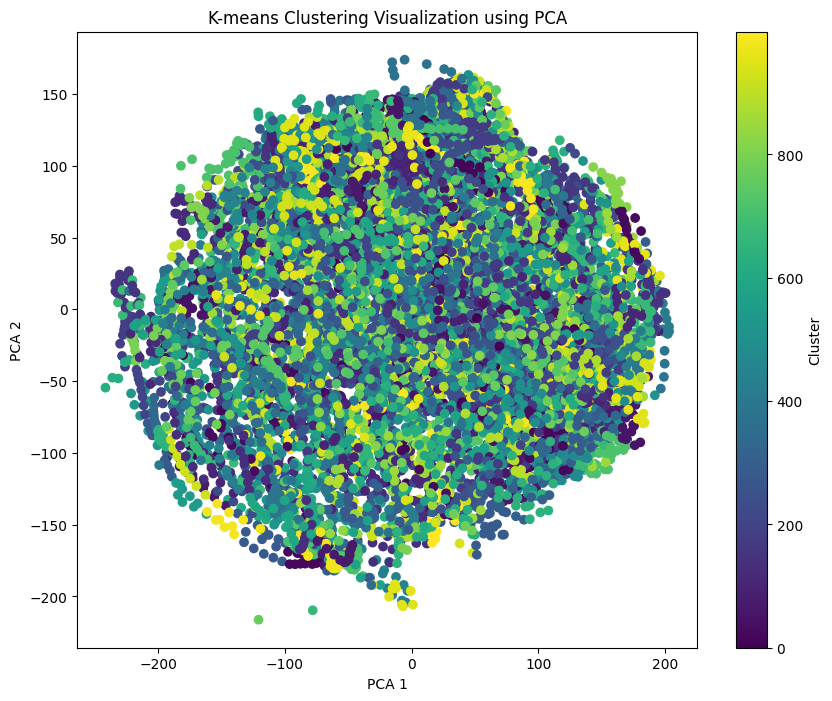

In [31]:
# PCA Visualization
print("PCA Visualization:")
visualize_clusters(embedding[:, :2], cluster_labels, 'PCA')



In [21]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from typing import Tuple, List

from sklearn.decomposition import PCA
import os

def run_kmeans_on_eks_output(
    eks_data_path: str,
    n_clusters: int = 1000
) -> Tuple[pd.DataFrame, List[str]]:
    """Step 4: Perform K-means clustering on EKS output data."""
    with open(eks_data_path, 'r') as f:
        header = [f.readline().strip() for _ in range(2)]

    # Read the EKS data
    eks_data = pd.read_csv(eks_data_path, skiprows=2)

    # Extract x and y coordinates
    x_coords = eks_data.filter(regex='^x').values
    y_coords = eks_data.filter(regex='^y').values

    # Stack x and y coordinates
    coords = np.hstack((x_coords, y_coords))

    # Determine the number of components for PCA
    n_components = min(coords.shape[0], coords.shape[1], 32)

    # Perform PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    embedding = pca.fit_transform(coords)

    # Adjust number of clusters if necessary
    n_clusters = min(n_clusters, embedding.shape[0])

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embedding)

    # Find the frame closest to each cluster center
    centers = kmeans.cluster_centers_
    distances = np.linalg.norm(embedding[:, None, :] - centers[None, :, :], axis=2)
    prototype_indices = np.argmin(distances, axis=0)

    # Get the full rows for the prototype frames
    prototype_frames = eks_data.iloc[prototype_indices]

    return prototype_frames, header


# Set the path to your EKS output file
eks_data_path = os.path.join(frame_selection_path, 'step_4_all_eks_output_low_stdev_frames.csv')

# Run k-means clustering and get prototype frames
prototype_frames, header = run_kmeans_on_eks_output(eks_data_path, n_clusters=1000)

# Display the first few prototype frames
print("First few prototype frames:")
print(prototype_frames.head())

# Save the prototype frames with the original header
output_file = os.path.join(frame_selection_path, 'step_5_kmeans_prototype_frames.csv')
with open(output_file, 'w') as f:
    f.write('\n'.join(header) + '\n')
    prototype_frames.to_csv(f, index=False)

print(f"\nPrototype frames saved to {output_file}")
print(f"Number of prototype frames: {len(prototype_frames)}")

First few prototype frames:
                            coords           x           y         x.1  \
0  031309_A29_Block14_BCfe1_t/4944  166.583252  218.947296  137.039520   
1  031309_A29_Block14_BCfe1_t/4951  167.871262  219.435959  135.927597   

          y.1         x.2         y.2         x.3         y.3        x.4  ...  \
0  225.760895  156.277191  193.978165  134.644745  200.873413  96.858871  ...   
1  225.269653  155.494171  196.306061  134.911240  201.539886  96.887054  ...   

          x.9         y.9        x.10        y.10        x.11        y.11  \
0  605.383545  233.776596  588.121521  221.552689  555.885071  189.827133   
1  606.166748  235.308472  589.475891  222.943542  556.397888  190.724686   

         x.12        y.12        x.13        y.13  
0  605.137817  181.362854  572.483276  153.545593  
1  606.662964  181.450043  573.612061  153.563202  

[2 rows x 29 columns]

Prototype frames saved to /teamspace/studios/this_studio/outputs/crim13/hand=500_pseudo=1000/

In [27]:
import csv
import os
from typing import List

def update_coordinates(valid_keypoints_path: str, selected_frames_path: str) -> List[List[str]]:
    """Update coordinates based on valid keypoints and selected frames data."""
    valid_keypoints = set()
    with open(valid_keypoints_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header
        for row in reader:
            valid_keypoints.add((row[0], row[1]))  # (image_path, body_part)

    with open(selected_frames_path, 'r') as f:
        selected_data = list(csv.reader(f))

    headers = selected_data[:2]
    body_parts = headers[1][1::2]

    coords_row = ['coords']
    for col in selected_data[2][1:]:
        coords_row.append(col[0] if col.startswith(('x', 'y')) else col)

    updated_headers = headers + [coords_row]
    updated_data = updated_headers.copy()

    for row in selected_data[3:]:
        frame = row[0]
        new_row = [frame]
        for i, body_part in enumerate(body_parts):
            if (frame, body_part) in valid_keypoints:
                new_row.extend([row[2*i+1], row[2*i+2]])
            else:
                new_row.extend(['NaN', 'NaN'])
        updated_data.append(new_row)

    return updated_data

step_5_file_path = os.path.join(frame_selection_path, 'step_5_kmeans_prototype_frames.csv')

updated_data = update_coordinates(combined_output_file, step_5_file_path)

# Output updated data to a new CSV file
step_6_file_path = os.path.join(frame_selection_path, 'step_6_maskingNaN_file.csv')
with open(step_6_file_path, 'w', newline='') as f:
    csv.writer(f).writerows(updated_data)

print(f"Updated coordinates have been saved to {step_6_file_path}")

Updated coordinates have been saved to /teamspace/studios/this_studio/outputs/crim13/hand=500_pseudo=1000/post-quality-frame/step_6_maskingNaN_file.csv


In [ ]:
###TODO: Do not use this function. this is to simply extract frames to check for quality of the cluster for meeting with Liam

from typing import Tuple, List
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os


def run_kmeans_and_select_frames(
    eks_data_path: str,
    output_dir: str,
    n_clusters: int = 1000,
    frames_per_thousand: int = 5
) -> Tuple[pd.DataFrame, List[str]]:
    """Perform K-means clustering on EKS output data and select representative frames."""
    with open(eks_data_path, 'r') as f:
        header = [f.readline().strip() for _ in range(2)]

    eks_data = pd.read_csv(eks_data_path, skiprows=2, index_col=0)

    x_coords = eks_data.filter(regex='^x').values
    y_coords = eks_data.filter(regex='^y').values
    coords = np.hstack((x_coords, y_coords))

    n_components = min(coords.shape[0], coords.shape[1], 32)
    pca = PCA(n_components=n_components)
    embedding = pca.fit_transform(coords)

    n_clusters = min(n_clusters, embedding.shape[0])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embedding)

    centers = kmeans.cluster_centers_
    distances = np.linalg.norm(embedding[:, None, :] - centers[None, :, :], axis=2)
    
    n_select = max(1, int(n_clusters * frames_per_thousand / 1000))
    top_indices = np.argsort(distances, axis=0)[:n_select, :]
    
    selected_indices = []
    selected_clusters = []
    for cluster in range(n_clusters):
        for idx in top_indices[:, cluster]:
            if idx not in selected_indices:
                selected_indices.append(idx)
                selected_clusters.append(cluster)

    selected_frames = eks_data.iloc[selected_indices].copy()
    selected_frames['cluster'] = selected_clusters

    # Modify the index
    def format_frame_path(frame):
        parts = frame.split('/')
        video_name = parts[0]
        frame_number = int(parts[1])
        return f"labeled-data/{video_name}/img{str(frame_number).zfill(8)}.png"

    selected_frames.index = selected_frames.index.map(format_frame_path)
    selected_frames.index.name = 'image_path'

    # Modify header to reflect the new index format
    header[1] = 'image_path,' + header[1]
    header[1] += ',cluster'

    # Export selected frames to CSV
    output_file = os.path.join(output_dir, 'selected_frames.csv')
    with open(output_file, 'w') as f:
        f.writelines([h + '\n' for h in header])
        selected_frames.to_csv(f)

    print(f"Selected {len(selected_frames)} frames, saved to {output_file}")

    return selected_frames, header



# Usage example:
eks_data_path = os.path.join(frame_selection_path, 'step_4_all_eks_output_low_stdev_frames.csv')
output_dir = '/teamspace/studios/this_studio/'
selected_frames, header = run_kmeans_and_select_frames(eks_data_path, output_dir)